In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pickle

# --- Load & preprocess ---
df = pd.read_csv('titanic.csv')
df = df.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']) # Drop non-numeric columns and PassengerId
df.loc[df['Sex'] == 'male', 'Sex'] = 1
df.loc[df['Sex'] == 'female', 'Sex'] = 0

# Handle missing 'Age' values
df['Age'] = df['Age'].fillna(df['Age'].mean())


X = df.drop('Survived', axis=1).values.astype(np.float32)
y = df['Survived'].values.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# --- Build & train ---
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(6,)),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_val, y_val))

# --- Save for Streamlit app ---
model.save('titanic.h5')
with open('training_history', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.6171 - loss: 6.4558 - val_acc: 0.6257 - val_loss: 1.1456
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6900 - loss: 0.8741 - val_acc: 0.5419 - val_loss: 0.6712
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.6616 - loss: 0.6482 - val_acc: 0.5531 - val_loss: 0.6607
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6242 - loss: 0.7009 - val_acc: 0.6089 - val_loss: 0.6665
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7246 - loss: 0.6215 - val_acc: 0.5866 - val_loss: 0.6470
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6472 - loss: 0.6516 - val_acc: 0.6145 - val_loss: 0.6466
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7047 - loss: 0.5976 - val_acc: 0.6257 - val_loss: 0.6354
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7006 - loss: 0.6184 - val_acc: 0.6536 - val_loss: 0.6302
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7210 -

In [23]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.src.saving import load_model
import matplotlib.pyplot as plt
from PIL import Image
import pickle

st.set_page_config(page_title="Titanic Survival Predictor")
st.title("🚢 Predict Your Survival on the Titanic")

# --- Image ---
img = Image.open("/content/Titanic.png")
st.image(img, width=600)

# --- Load model & history ---
model = load_model("titanic.h5")
history = pickle.load(open("training_history", "rb"))

# --- Sidebar input ---
def user_input():
    st.sidebar.header("Passenger Details")
    Pclass = st.sidebar.slider("Pclass", 1, 3)
    sex = st.sidebar.selectbox("Sex", ("Male", "Female"))
    age = st.sidebar.slider("Age", 0, 80)
    n_siblings_spouses = st.sidebar.slider("Siblings/Spouses", 0, 3)
    n_parents_children = st.sidebar.slider("Parents/Children", 0, 3)
    fare = st.sidebar.slider("Fare", 0, 200)
    sex = 1 if sex == "Male" else 0
    return np.array([[Pclass, sex, age, n_siblings_spouses, n_parents_children, fare]], dtype=np.float32)

data = user_input()
prediction = model.predict(data)
pred = int(round(prediction[0][0]))

if pred == 0:
    st.error("You did not survive")
else:
    st.success("You survived!")

# --- Training plots ---
def plot_data():
    loss_train = history["loss"]
    loss_val = history["val_loss"]
    epochs = range(1, len(loss_train) + 1)

    fig, ax = plt.subplots()
    ax.plot(epochs, loss_train, "g", label="Training Loss")
    ax.plot(epochs, loss_val, "b", label="Validation Loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    st.pyplot(fig)

    acc_train = history["acc"]
    acc_val = history["val_acc"]
    fig, ax = plt.subplots()
    ax.plot(epochs, acc_train, "g", label="Training Accuracy")
    ax.plot(epochs, acc_val, "b", label="Validation Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    st.pyplot(fig)

st.header("Model Performance")
plot_data()

Overwriting app.py


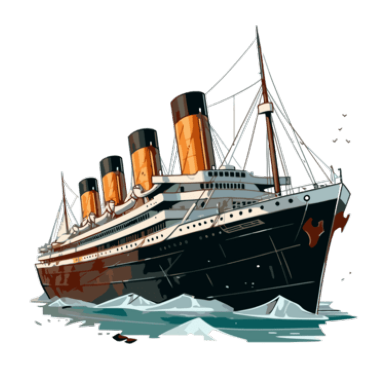

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/Titanic.png")
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()

In [25]:
import tensorflow as tf
import numpy as np
from keras.src.saving import load_model

# Load the saved model
model = load_model("titanic.h5")

# Create a sample passenger data
# The order of features should be: Pclass, Sex (1=male, 0=female), Age, SibSp, Parch, Fare
sample_passenger = np.array([[1, 1, 30, 0, 0, 50]], dtype=np.float32) # Example: 1st class, Male, 30 years, 0 siblings/spouses, 0 parents/children, 50 fare

# Make a prediction
prediction = model.predict(sample_passenger)

# Display the prediction
print("Prediction (0 = Did not survive, 1 = Survived):", round(prediction[0][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction (0 = Did not survive, 1 = Survived): 1
